In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
import os

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [4]:
os.getcwd()

'/Users/chloebergsma-safar/Desktop/Metis/NBM_Classification_Project'

# Read in Housing Maintenance Code Violations

Violations of order #s 616 or 617, which correspond to lead-based paint violations that both constitute class C "immediately hazardous" violations

In [5]:
# this Housing Maintenance Code Violations dataset uses the following filter: OrderNumber is 616 OR 617 (lead-based paint)
violations = pd.read_csv('Housing_Maintenance_Code_Violations_lead.csv')

In [6]:
violations.shape

(170281, 41)

In [7]:
violations.iloc[:,10:20]

,Postcode,Apartment,Story,Block,Lot,Class,InspectionDate,ApprovedDate,OriginalCertifyByDate,OriginalCorrectByDate
0,10451.0,31F,5,2482,1,C,10/08/2013,10/09/2013,11/12/2013,11/07/2013
1,10457.0,3A,3,2825,10,C,10/09/2013,10/17/2013,11/20/2013,11/15/2013
2,10457.0,3A,3,2825,10,C,10/09/2013,10/17/2013,11/20/2013,11/15/2013
3,10466.0,2F,2,4840,57,C,11/20/2013,12/03/2013,01/06/2014,01/01/2014
4,11358.0,2C,2,5331,8,C,10/19/2013,10/26/2013,11/30/2013,11/25/2013
...,...,...,...,...,...,...,...,...,...,...
170276,11226.0,A2,1,5221,86,C,12/14/2021,12/17/2021,01/18/2022,01/13/2022
170277,11226.0,A2,1,5221,86,C,12/14/2021,12/17/2021,01/18/2022,01/13/2022
170278,10458.0,B,1,3309,25,C,10/18/2006,10/19/2006,11/20/2006,11/15/2006
170279,10458.0,B,1,3309,25,C,10/18/2006,10/19/2006,11/20/2006,11/15/2006


In [8]:
violations.columns

Index(['ViolationID', 'BuildingID', 'RegistrationID', 'BoroID', 'Borough',
       'HouseNumber', 'LowHouseNumber', 'HighHouseNumber', 'StreetName',
       'StreetCode', 'Postcode', 'Apartment', 'Story', 'Block', 'Lot', 'Class',
       'InspectionDate', 'ApprovedDate', 'OriginalCertifyByDate',
       'OriginalCorrectByDate', 'NewCertifyByDate', 'NewCorrectByDate',
       'CertifiedDate', 'OrderNumber', 'NOVID', 'NOVDescription',
       'NOVIssuedDate', 'CurrentStatusID', 'CurrentStatus',
       'CurrentStatusDate', 'NovType', 'ViolationStatus', 'RentImpairing',
       'Latitude', 'Longitude', 'CommunityBoard', 'CouncilDistrict',
       'CensusTract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [10]:
# look at values in ViolationStatus column

violations['ViolationStatus'].value_counts()

Close    123946
Open      46335
Name: ViolationStatus, dtype: int64

In [11]:
# drop closed violations

violations_open = violations.loc[violations['ViolationStatus'] == 'Open']

In [12]:
# look at values in CurrentStatus column

violations_open['CurrentStatus'].value_counts()

DEFECT LETTER ISSUED                        14407
NOV SENT OUT                                13625
FIRST NO ACCESS TO RE- INSPECT VIOLATION     8828
CERTIFICATION POSTPONMENT GRANTED            2316
NOT COMPLIED WITH                            1595
INVALID CERTIFICATION                        1583
NOV CERTIFIED LATE                           1230
CERTIFICATION POSTPONMENT DENIED             1213
SECOND NO ACCESS TO RE-INSPECT VIOLATION      748
VIOLATION WILL BE REINSPECTED                 558
CIV14 MAILED                                  134
VIOLATION OPEN                                 45
VIOLATION REOPEN                               35
NOV CERTIFIED ON TIME                          16
FALSE CERTIFICATION                             2
Name: CurrentStatus, dtype: int64

In [13]:
# create new column of for 'Not Complied With' vs everything else from CurrentStatus

violations_open['Not_Complied_With'] = violations_open['CurrentStatus'].apply(lambda x: 1 if x == 'NOT COMPLIED WITH' else 0)

<ipython-input-13-84766d2ca133>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations_open['Not_Complied_With'] = violations_open['CurrentStatus'].apply(lambda x: 1 if x == 'NOT COMPLIED WITH' else 0)


In [14]:
# create new column of for ('Not Complied With' or 'False Certification') vs everything else from CurrentStatus

statuses = ['NOT COMPLIED WITH', 'FALSE CERTIFICATION']

violations_open['Not_Complied_With_False_Cert'] = violations_open['CurrentStatus'].apply(lambda x: 1 if x in statuses else 0)

<ipython-input-14-2d379c3cf3e8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations_open['Not_Complied_With_False_Cert'] = violations_open['CurrentStatus'].apply(lambda x: 1 if x in statuses else 0)


In [15]:
violations_open['Not_Complied_With'].value_counts()

0    44740
1     1595
Name: Not_Complied_With, dtype: int64

In [16]:
violations_open['Not_Complied_With_False_Cert'].value_counts()

0    44738
1     1597
Name: Not_Complied_With_False_Cert, dtype: int64

In [17]:
# frequency of cases resulting in 'Not Complied With' or 'False Certification' status

print(len(violations_open[violations_open['Not_Complied_With_False_Cert'] == 1])/len(violations_open))

0.03446638610121938


In [18]:
# convert date columns to datetime

date_cols = ['NOVIssuedDate','CurrentStatusDate']

violations_open[date_cols] = violations_open[date_cols].apply(pd.to_datetime)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [19]:
# create new column that calculates the # of days between NOVIssuedDate and CurrentStatus

violations_open['Days_to_status'] = violations_open['CurrentStatusDate'] - violations_open['NOVIssuedDate']

<ipython-input-19-116c3e1fc7d3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  violations_open['Days_to_status'] = violations_open['CurrentStatusDate'] - violations_open['NOVIssuedDate']


In [20]:
violations_open.shape

(46335, 44)

In [21]:
violations_open.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46335 entries, 24 to 170277
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   ViolationID                   46335 non-null  int64          
 1   BuildingID                    46335 non-null  int64          
 2   RegistrationID                46335 non-null  int64          
 3   BoroID                        46335 non-null  int64          
 4   Borough                       46335 non-null  object         
 5   HouseNumber                   46335 non-null  object         
 6   LowHouseNumber                46335 non-null  object         
 7   HighHouseNumber               46335 non-null  object         
 8   StreetName                    46335 non-null  object         
 9   StreetCode                    46335 non-null  int64          
 10  Postcode                      46334 non-null  float64        
 11  Apartment    

In [22]:
# drop columns not needed for analysis

violations_open_rev = violations_open.drop(['RegistrationID','Borough','HouseNumber','LowHouseNumber',
                                           'HighHouseNumber','StreetName','StreetCode','Apartment',
                                           'Class','InspectionDate','ApprovedDate','OriginalCertifyByDate',
                                           'OriginalCorrectByDate','NewCertifyByDate','NewCorrectByDate',
                                           'CertifiedDate','NOVID','NOVDescription','NOVIssuedDate',
                                           'CurrentStatusID','CurrentStatus','NovType','ViolationStatus',
                                           'RentImpairing','Latitude','Longitude','CouncilDistrict',
                                           'NTA'],axis=1)

In [23]:
violations_open_rev.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46335 entries, 24 to 170277
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   ViolationID                   46335 non-null  int64          
 1   BuildingID                    46335 non-null  int64          
 2   BoroID                        46335 non-null  int64          
 3   Postcode                      46334 non-null  float64        
 4   Story                         46299 non-null  object         
 5   Block                         46335 non-null  int64          
 6   Lot                           46335 non-null  int64          
 7   OrderNumber                   46335 non-null  int64          
 8   CurrentStatusDate             46335 non-null  datetime64[ns] 
 9   CommunityBoard                46328 non-null  float64        
 10  CensusTract                   46328 non-null  float64        
 11  BIN          

In [44]:
# examine Story column

violations_open_rev['Story'].value_counts()

2                 13109
3                 10140
1                  9622
4                  6427
5                  3559
6                  2169
Basement            611
7                   134
10                  107
8                    58
9                    55
All Stories          41
Cellar               40
11                   40
12                   30
15                   30
Yards / Courts       28
14                   26
13                   20
Fire Escape           9
24                    7
17                    6
16                    5
23                    5
Penthouse             5
20                    4
22                    3
19                    2
18                    2
28                    1
26                    1
36                    1
32                    1
908                   1
Name: Story, dtype: int64

In [57]:
# create new column for recoding story and replace nan in new column with 999

fl_0 = ['Basement','Cellar']
fl_999 = ['All Stories','Yards / Courts','Fire Escape','Penthouse','908', np.nan]

def story_rev(row):
    if row['Story'] in fl_0:
        return int(0)
    elif row['Story'] in fl_999:
        return int(999)
    else:
        return int(row['Story'])
    
violations_open_rev['Story_rev'] = violations_open_rev.apply(lambda row: story_rev(row),axis=1)

In [60]:
# create column that counts # of violations per buildingID

violations_open_rev['Violations_Count'] = violations_open_rev.groupby('BuildingID')['ViolationID'].transform('count')

In [61]:
violations_open_rev.sort_values(by='Violations_Count').head()

,ViolationID,BuildingID,BoroID,Postcode,Story,Block,Lot,OrderNumber,CurrentStatusDate,CommunityBoard,CensusTract,BIN,BBL,Not_Complied_With,Not_Complied_With_False_Cert,Days_to_status,Violations_Count,Story_rev
77565,12338168,56477,2,10464.0,3,5646,2,617,2018-08-25,10.0,516.0,2082784.0,2.056460e+09,0,0,130 days,1,3
76173,12169166,821715,3,11238.0,1,1148,5,616,2018-01-04,8.0,305.0,3348539.0,3.011480e+09,0,0,0 days,1,1
149567,6651338,4179,1,10039.0,1,2046,29,617,2013-07-19,10.0,23502.0,1060861.0,1.020460e+09,0,0,2314 days,1,1
76154,12165885,832394,3,NaN,3,8543,7501,616,2018-01-02,NaN,NaN,NaN,NaN,0,0,0 days,1,3
149579,9429369,2522,1,10029.0,5,1617,7501,616,2020-02-27,11.0,17402.0,1086046.0,1.016178e+09,0,0,2851 days,1,5


0    0.965534
1    0.034466
Name: Not_Complied_With_False_Cert, dtype: float64


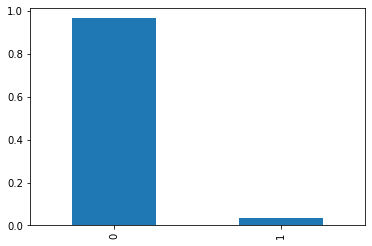

In [62]:
# take a look at our target variable, Not_Complied_With_False_Cert

target_pcts = violations_open_rev.Not_Complied_With_False_Cert.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar') # it's very imbalanced!

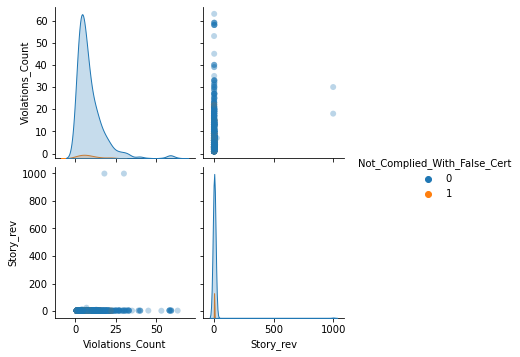

In [63]:
def plot_features(df, sample_size=500):
    
    sample = (df.drop(['ViolationID','BuildingID','BoroID','Postcode','Story','Block','Lot','OrderNumber',
                       'CurrentStatusDate','CommunityBoard','CensusTract','BIN','BBL','Not_Complied_With',
                       'Days_to_status'],axis=1)
                .sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='Not_Complied_With_False_Cert', plot_kws=dict(alpha=.3, edgecolor='none'))

plot_features(violations_open_rev)

In [65]:
# this function mimics train_test_split but ensures no violations are in both the train and test sets

def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_violations = df['ViolationID'].unique() 
    test_violations = rs.choice(total_violations, 
                           size=int(total_violations.shape[0] * test_size), 
                           replace=False)

    df_tr_val = df[~df['ViolationID'].isin(test_violations)]
    df_te = df[df['ViolationID'].isin(test_violations)] 

    y_tr_val, y_te = df_tr_val['Not_Complied_With_False_Cert'], df_te['Not_Complied_With_False_Cert']
    X_tr_val = df_tr_val.drop(['ViolationID','BuildingID','BoroID','Postcode','Story','Block',
                              'Lot','OrderNumber','CurrentStatusDate','CommunityBoard','CensusTract',
                              'BIN','BBL','Not_Complied_With','Days_to_status','Not_Complied_With_False_Cert'],axis=1) 
    X_te = df_te.drop(['ViolationID','BuildingID','BoroID','Postcode','Story','Block',
                              'Lot','OrderNumber','CurrentStatusDate','CommunityBoard','CensusTract',
                              'BIN','BBL','Not_Complied_With','Days_to_status','Not_Complied_With_False_Cert'],axis=1)
 
    scaler = StandardScaler()
    X_tr_val_scaled = scaler.fit_transform(X_tr_val)
    X_te_scaled = scaler.fit_transform(X_te)
    
    return X_tr_val_scaled, X_te_scaled, y_tr_val, y_te

In [67]:
X_tr_val_scaled, X_te_scaled, y_tr_val, y_te = get_user_split_data(violations_open_rev)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_tr_val_scaled, y_tr_val)

kf = KFold(n_splits=5, shuffle=True, random_state = 71)
cv_results = cross_validate(lr, X_tr_val_scaled, y_tr_val, cv=kf, scoring='f1')

print(f"recall: {(cv_results['test_score'])}")
print("")
print(f"mean recall: {(np.mean(cv_results['test_score'])):.3f}")

recall: [0. 0. 0. 0. 0.]

mean recall: 0.000


In [594]:
X_tr_val

,Violations_Count
24,11
26,6
27,6
29,6
30,6
...,...
170272,5
170273,7
170274,7
170276,5


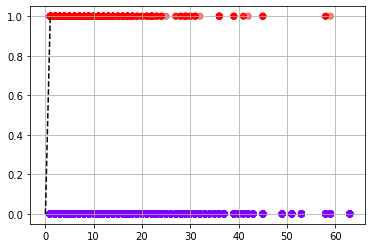

In [597]:
def visualize(X, y, bdry='diag'):
    c = cm.rainbow(np.linspace(0, 1, 2))
    plt.scatter(X, y, color=[c[i] for i in y], alpha=.5)
    
    #Plot the true decision boundary
    if bdry == 'diag':
        plt.plot([0, 1], [0, 1], 'k--')
    elif bdry == 'quadrant':
        plt.plot([0, 1],[0.5, 0.5], 'k--')
        
        plt.plot([0.5, 0.5],[0, 1], 'k--')
        
    plt.grid(True)
    

visualize(np.array(X_tr_val), np.array(y_tr_val))

In [312]:
# drop rows with null values in 'NOVIssuedDate' column

#violations_rev.dropna(subset=['NOVIssuedDate'], inplace=True)

In [313]:
# create a CertifyByDate column that assigns values from OriginalCertifyByDate or NewCertifyByDate

#def program(violations_rev):
    #if pd.isnull(violations_rev['NewCertifyByDate']) :
        #return violations_rev['OriginalCertifyByDate']
    #else :
        #return violations_rev['NewCertifyByDate']

#violations_rev['CertifyByDate'] = violations_rev.apply(program, axis=1)

In [317]:
# create df filtered to closed violations whose current status is not 'VIOLATION WILL BE REINSPECTED'

#violations_closed = violations_rev[(violations_rev.ViolationStatus == 'Close') & 
                                   #(violations_rev.CurrentStatus != 'VIOLATION WILL BE REINSPECTED')]

In [504]:
# create a column that calculates # of days between OriginalCertifyByDate and CurrentStatusDate
    # or InspectionDate)

#def days_to_close(violations_closed):
    #if violations_closed['Status_from_Certify'] < pd.Timedelta(0, unit='d'):
       # return violations_closed['CurrentStatusDate'] - violations_closed['OriginalCertifyByDate']
   # else:
       # return violations_closed['Status_from_Certify']

#violations_closed['Days_to_close'] = violations_closed.apply(days_to_close, axis=1)

In [505]:
# look at histogram of column representing # of days between (OriginalCertifyByDate or NewCertifyByDate) and 
    # CurrentStatusDate columns

#violations_closed['Days_to_close'].dt.days.hist()

In [506]:
# look at box and whiskers plot of Days_to_close column

#plt.boxplot(violations_closed['Days_to_close'].dt.days)

In [507]:
# find outliers in Days_to_close

# First quartile (Q1)
#Q1 = np.percentile(violations_closed['Days_to_close'].dt.days, 25, interpolation = 'midpoint')

# Third quartile (Q3)
#Q3 = np.percentile(violations_closed['Days_to_close'].dt.days, 75, interpolation = 'midpoint')

# Interquaritle range (IQR)
#IQR = Q3 - Q1

# outliers more than 1.5 times the IQR below Q1
#outliers_below = Q1 - 1.5 * IQR 

# outliers more than 1.5 times the IQR above Q3
#outliers_above = Q3 + 1.5 * IQR

In [508]:
# create new column that codes for Days_to_close <= median or > median

#violations_closed_no_outs['target'] = np.where(violations_closed_no_outs['Days_to_close'].dt.days<=(np.median(violations_closed['Days_to_close'].dt.days)), 1, 0)

# Read in HPD Buildings

In [367]:
buildings = pd.read_csv('Buildings_Subject_to_HPD_Jurisdiction.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [368]:
buildings.head()

,BuildingID,BoroID,Boro,HouseNumber,LowHouseNumber,HighHouseNumber,StreetName,Zip,Block,Lot,...,ManagementProgram,DoBBuildingClassID,DoBBuildingClass,LegalStories,LegalClassA,LegalClassB,RegistrationID,LifeCycle,RecordStatusID,RecordStatus
0,71635,2,BRONX,860,860,860,EAST 231 STREET,10466.0,4855,83,...,PVT,24.0,NOT AVAILABLE,1.0,1.0,0.0,0,Building,1,Active
1,311388,3,BROOKLYN,151,151,151,HERKIMER STREET,11216.0,1861,54,...,PVT,25.0,2 FAMILY HOUSE,3.0,2.0,0.0,0,Building,1,Active
2,742421,5,STATEN ISLAND,8,8,8,GRISSOM AVENUE,10314.0,2015,7501,...,PVT,23.0,1 FAMILY HOUSE,2.0,1.0,0.0,0,Building,1,Active
3,680250,4,QUEENS,99-08,99-08,99-08,METROPOLITAN AVENUE,11375.0,3894,34,...,PVT,24.0,NOT AVAILABLE,2.0,2.0,0.0,0,Building,1,Active
4,946265,3,BROOKLYN,539A,539A,539A,GREENE AVENUE,11216.0,1794,67,...,PVT,25.0,2 FAMILY HOUSE,3.0,2.0,NaN,812803,UnderConstruction,1,Active


In [369]:
buildings.columns

Index(['BuildingID', 'BoroID', 'Boro', 'HouseNumber', 'LowHouseNumber',
       'HighHouseNumber', 'StreetName', 'Zip', 'Block', 'Lot', 'BIN',
       'CommunityBoard', 'CensusTract', 'ManagementProgram',
       'DoBBuildingClassID', 'DoBBuildingClass', 'LegalStories', 'LegalClassA',
       'LegalClassB', 'RegistrationID', 'LifeCycle', 'RecordStatusID',
       'RecordStatus'],
      dtype='object')

In [370]:
buildings.shape

(344021, 23)

# Merge violations and hpd buildings data

In [425]:
violations_buildings = pd.merge(violations_closed_no_outs, buildings,
                                            how='left', on='BuildingID', suffixes=('_vio', '_build'))

In [426]:
violations_buildings.columns

Index(['BuildingID', 'BoroID_vio', 'Postcode', 'Story', 'Block_vio', 'Lot_vio',
       'Latitude', 'Longitude', 'CommunityBoard_vio', 'CensusTract_vio',
       'BIN_vio', 'BBL', 'Days_to_close', 'target', 'BoroID_build', 'Boro',
       'HouseNumber', 'LowHouseNumber', 'HighHouseNumber', 'StreetName', 'Zip',
       'Block_build', 'Lot_build', 'BIN_build', 'CommunityBoard_build',
       'CensusTract_build', 'ManagementProgram', 'DoBBuildingClassID',
       'DoBBuildingClass', 'LegalStories', 'LegalClassA', 'LegalClassB',
       'RegistrationID', 'LifeCycle', 'RecordStatusID', 'RecordStatus'],
      dtype='object')

In [427]:
# drop columns not needed

violations_buildings.drop(['BoroID_build', 'Boro', 'HouseNumber', 'LowHouseNumber','HighHouseNumber', 'StreetName',
                          'Zip', 'Block_build', 'Lot_build', 'BIN_build', 'CommunityBoard_build', 'CensusTract_build',
                          'DoBBuildingClassID','RegistrationID', 'RecordStatusID'],axis=1,inplace=True)

In [428]:
violations_buildings.columns

Index(['BuildingID', 'BoroID_vio', 'Postcode', 'Story', 'Block_vio', 'Lot_vio',
       'Latitude', 'Longitude', 'CommunityBoard_vio', 'CensusTract_vio',
       'BIN_vio', 'BBL', 'Days_to_close', 'target', 'ManagementProgram',
       'DoBBuildingClass', 'LegalStories', 'LegalClassA', 'LegalClassB',
       'LifeCycle', 'RecordStatus'],
      dtype='object')

# Read in building water and energy consumption data

In [388]:
water_energy_buildings = pd.read_csv('Energy_and_Water_Data_Disclosure_for_Local_Law_84_2021__Data_for_Calendar_Year_2020_.csv')

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (9,15,218,219) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [418]:
water_energy_buildings.shape

(28067, 2)

In [419]:
# drop columns not needed for merge

water_energy_buildings = water_energy_buildings[['NYC Building Identification Number (BIN)', 'Year Built']]

# Merge violations_buildings and building water and energy consumption data

In [432]:
violations_buildings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117219 entries, 0 to 117218
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   BuildingID          117219 non-null  int64          
 1   BoroID_vio          117219 non-null  int64          
 2   Postcode            117219 non-null  float64        
 3   Story               117188 non-null  object         
 4   Block_vio           117219 non-null  int64          
 5   Lot_vio             117219 non-null  int64          
 6   Latitude            117217 non-null  float64        
 7   Longitude           117217 non-null  float64        
 8   CommunityBoard_vio  117217 non-null  float64        
 9   CensusTract_vio     117217 non-null  float64        
 10  BIN_vio             117141 non-null  float64        
 11  BBL                 117141 non-null  float64        
 12  Days_to_close       117219 non-null  timedelta64[ns]
 13  target        

In [430]:
water_energy_buildings.dtypes

NYC Building Identification Number (BIN)    object
Year Built                                   int64
dtype: object

In [437]:
# drop BIN_vio with null values in violations_buildings and then convert BIN_vio to int then str for merge with 
    # water_energy_buildings

violations_buildings.dropna(subset=['BIN_vio'],inplace=True)

violations_buildings['BIN_vio'] = violations_buildings['BIN_vio'].astype(int)
violations_buildings['BIN_vio'] = violations_buildings['BIN_vio'].astype(str)

In [438]:
violations_buildings['BIN_vio'].value_counts()

2002047    166
3120374    162
1063331    159
2008060    143
2003497    143
          ... 
1062696      1
3072713      1
3117143      1
2007735      1
2093937      1
Name: BIN_vio, Length: 13879, dtype: int64

In [439]:
water_energy_buildings['NYC Building Identification Number (BIN)'].value_counts()

Not Available    112
0000000           26
2026596           23
1081667           10
4542595            6
                ... 
3126369            1
1056908            1
1090231            1
3816816            1
4009004            1
Name: NYC Building Identification Number (BIN), Length: 26723, dtype: int64

In [440]:
violations_buildings_yrbuilt = pd.merge(violations_buildings, water_energy_buildings,how='left',
                                        left_on='BIN_vio', right_on='NYC Building Identification Number (BIN)',suffixes=('_vio', '_yrbuilt'))

In [441]:
violations_buildings_yrbuilt.columns

Index(['BuildingID', 'BoroID_vio', 'Postcode', 'Story', 'Block_vio', 'Lot_vio',
       'Latitude', 'Longitude', 'CommunityBoard_vio', 'CensusTract_vio',
       'BIN_vio', 'BBL', 'Days_to_close', 'target', 'ManagementProgram',
       'DoBBuildingClass', 'LegalStories', 'LegalClassA', 'LegalClassB',
       'LifeCycle', 'RecordStatus', 'NYC Building Identification Number (BIN)',
       'Year Built'],
      dtype='object')

In [443]:
violations_buildings_yrbuilt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120001 entries, 0 to 120000
Data columns (total 23 columns):
 #   Column                                    Non-Null Count   Dtype          
---  ------                                    --------------   -----          
 0   BuildingID                                120001 non-null  int64          
 1   BoroID_vio                                120001 non-null  int64          
 2   Postcode                                  120001 non-null  float64        
 3   Story                                     119970 non-null  object         
 4   Block_vio                                 120001 non-null  int64          
 5   Lot_vio                                   120001 non-null  int64          
 6   Latitude                                  120001 non-null  float64        
 7   Longitude                                 120001 non-null  float64        
 8   CommunityBoard_vio                        120001 non-null  float64        
 9   Cens

In [444]:
# drop columns not needed

violations_buildings_yrbuilt.drop(['NYC Building Identification Number (BIN)'],axis=1,inplace=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f95222158b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9522215fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9522215520>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9522220730>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9522220ac0>],
 'means': []}

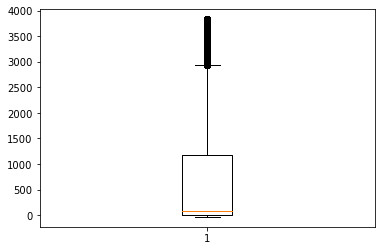

In [445]:
plt.boxplot(violations_buildings_yrbuilt['Days_to_close'].dt.days)